- Basic setup to simulate trajectories with 3 parameters (drift, bound, starting point) using Euler Mayurama  method
	- Obtain histograms and psychometrics
	- Compare to analytic solutions, explore the error of the approximation with dt
	- Explore dependence of histograms and psychometrics with parameter values
- Add time varying bound, variability in parameters
- Explore race models

- "Optogenetic manipulations"
	- "Sensory neurons" vs "Integrator neurons"
	- Bound "deletion"
        - Other ways?

- History effects
	- Explore updates on starting point and drifts
	- Also post error slowing (increase bounds after errors)

In [1]:
# @title Import packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.gridspec import GridSpec
import importlib
import random
from scipy.optimize import curve_fit
from statsmodels.distributions.empirical_distribution import ECDF

# import all functions defined in ddm.py
import ddm
import plottingddm as pddm

# set the font size of plots
font = {'size'   : 16}
plt.rc('font', **font)

In [16]:
# Reload all functions from the ddm.py file
# use after making changes in ddm.py.
importlib.reload(ddm)
importlib.reload(pddm)

<module 'plottingddm' from '/Users/marcocolnaghi/Documents/INCDP/Classes/DecisionMaking/indp22-ddm-simulation-project/code/plottingddm.py'>

In [14]:
# Properties for Plots

# Set this Parameter to true if you want to save figures
saveFig = False
expDPI = 900

colors = ['#2662E4', '#F02D3A']   # colors for correct/incorrect
colorsfordistributions = ['#49BCCE', '#000000','#F187DE']
colorgradient = ['#49BCCE', '#1396AB', '#000000', '#B664A7', '#F187DE'] # colors for manipulation plots

In [10]:
# Function to downsample the data (could be useful to reduce size of data)
def downsampleTraj(traj, t, dsFactor):
    ds_traj = traj[:,np.arange(0,t.size,dsFactor)]
    ds_t = t[np.arange(0,t.size,dsFactor)] 
    
    return ds_traj, ds_t

In [11]:
# Set the Seed for the Experiment
seed = 2

In [12]:
# Single Simulation - Basic Experiment - no opto -

mu = 0.5 # drift
theta = 1 # bound
z = 0.4 # starting point
sigma = 1 # noise std

# Define simulation parameters
n_trials = 1000
dt = .001
T = 10

# theta vector
t = np.arange(0, T, dt)
theta = theta*np.ones((t.size,1))

# Run single Simulation
S, traj = ddm.sim_ddm(mu, theta, z, sigma, n_trials, dt, T, seed=seed)

# Set downsampling factor to 1 to not ds.
dsFactor = 1
ds_traj, ds_t = downsampleTraj(traj, t, dsFactor)

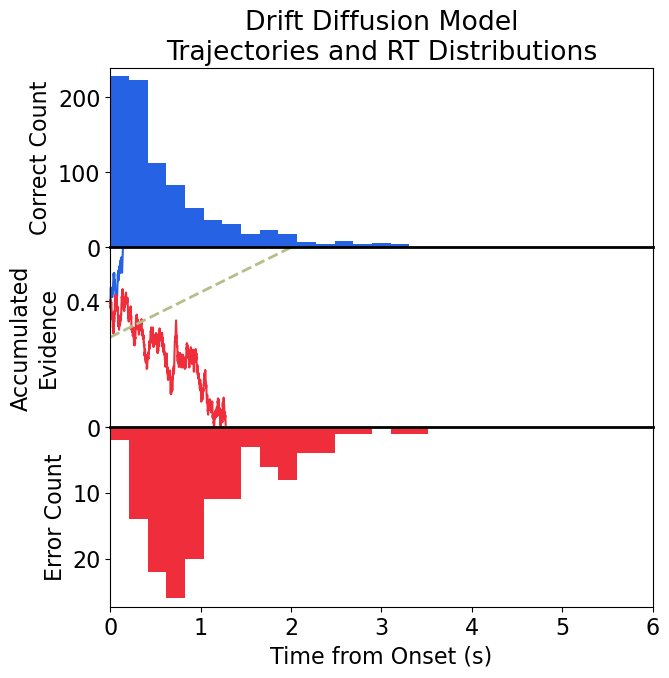

In [17]:
# Plot Trajectories with RT histograms
# Calculate Hits and Miss Trials
hits, errs = ddm.calc_hits_errs(S, mu)

# Set BinSize for RT Histogram
binsRT = np.linspace(0, 6, 30)

# Plot figure
fig = pddm.plot_trajectories_and_RT(S, hits, errs, ds_traj, mu, ds_t, z, binsRT, colors, export=saveFig)

if saveFig:
    fig.savefig('RTandSingleTraj.png', format='png', dpi= expDPI)


In [18]:
# Run multiple simulations with different drifts to compute the psychometric curve

# Define DDM parameters
theta = 1 # bound
z = 0 # starting point
sigma = 1 # noise std

# Define simulation parameters
n_trials = 1000
dt = .001
T = 10

# Create Vector for Theta
t = np.arange(0, T, dt)
theta = theta*np.ones((t.size,1))

# Run DDM simulations for different drifts
n_mu = 21
mu_list = 3*np.linspace(-1, 1, n_mu)
z_list = 0*np.concatenate((-np.ones((10,)),\
                              np.zeros((1,)),\
                              np.ones((10,))))

# Preallocate results
S_list = []
hits_list = []
errs_list = []

for i, mu in enumerate(mu_list):
    z = z_list[i]
    # Simulate trajectories
    S, _ = ddm.sim_ddm(mu, theta, z, sigma, n_trials, dt, T, seed=seed)

    # Save Variables
    S_list.append(S)
    hits, errs = ddm.calc_hits_errs(S, mu)
    hits_list.append(hits)
    errs_list.append(errs)

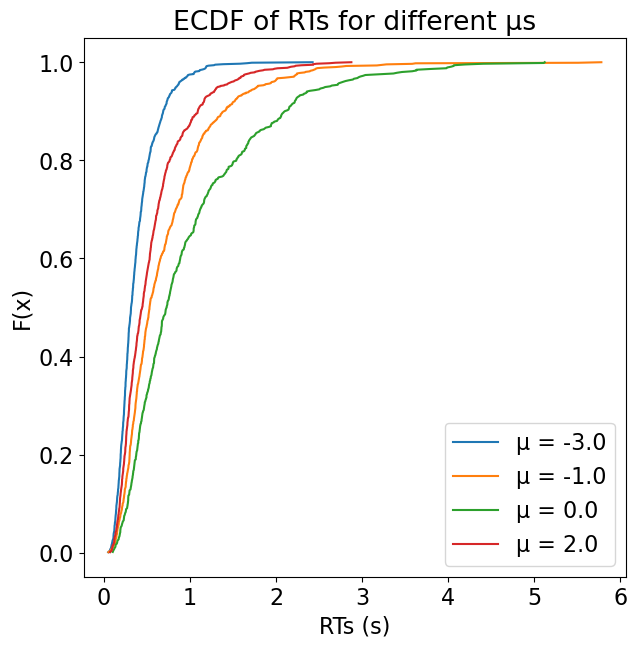

In [67]:
# Plot RTs ECDF for different Mu-s

fig = plt.figure(figsize=(7,7))
for idxMu in np.arange(1,n_mu,5):
    ecdf_RT = ECDF(S_list[idxMu][hits_list[idxMu],1][0])
    plt.plot(ecdf_RT.x,ecdf_RT.y, label = '\u03BC = '+str(np.round(mu_list[idxMu])))

plt.title('ECDF of RTs for different \u03BCs')
plt.xlabel('RTs (s)')
plt.ylabel('F(x)')

plt.legend()


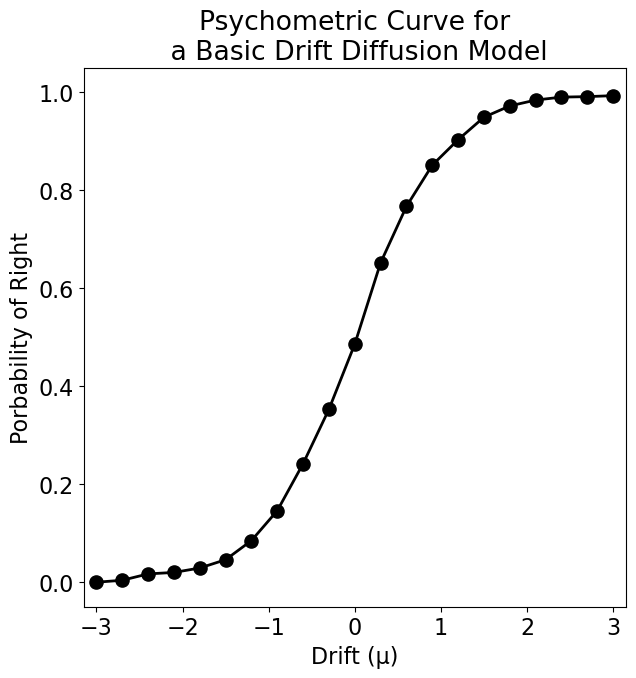

In [19]:
# Plot a psychometric curve
prob_a = ddm.calc_psychometric(S_list, mu_list)
fig = plt.figure(figsize=(7,7))
pddm.plot_psychometric(prob_a, mu_list, [0, 0, 0])
plt.plot(mu_list, prob_a, color='k', linewidth= 2)
plt.title('Psychometric Curve for\n a Basic Drift Diffusion Model')
plt.show()

if saveFig:
    fig.savefig('BasicPsychometricCurve.png', format='png', dpi=expDPI)

In [ ]:
# Plot the quantile probability function
fig = plt.figure(figsize=(7,7))
pddm.plot_quantile_prob_func(S_list, hits_list, errs_list, mu_list, prob_a)
plt.title('Quantile RTs against Response Probability')
plt.show()
fig.savefig('QuantileRTs.png', format='png', dpi=900)

In [ ]:
# Run DDM simulations for different drifts
n_mu = 21
n_z = 5
mu_list = 3*np.linspace(-1, 1, n_mu)
z_list = np.linspace(-0.8, 0.8, n_z)

# Preallocate results
fig = plt.figure(figsize=(7,7))
for idxZ, z in enumerate(z_list):
    S_list = []
    hits_list = []
    errs_list = []  
    for idxMu, mu in enumerate(mu_list):
        z = z_list[idxZ]
        mu = mu_list[idxMu]
        # Simulate trajectories
        S, _ = ddm.sim_ddm(mu, theta, z, sigma, n_trials, dt, T, seed=seed)
        S_list.append(S)
        hits, errs = ddm.calc_hits_errs(S, mu)
        hits_list.append(hits)
        errs_list.append(errs)
    
    prob_a = ddm.calc_psychometric(S_list, mu_list)
    pddm.plot_psychometric(prob_a, mu_list, colorgradient[idxZ])
    if z == 0:
        plt.plot(mu_list, prob_a, color='k', linewidth= 2)

plt.title('Psychometric Curve as\na function of Starting Point (z)')
fig.savefig('PsychometricCurve-differentSP.png', format='png', dpi=900)

In [ ]:
# Optogentic manipulation of the sensory detector, here we change the drift parameter mu

# Define DDM parameters
mu = 2 # drift
theta = 1 # bound
z = 0 # starting point
sigma = 1 # noise std
mfactor = 1
decayingconstant = 2
theta = theta*(np.exp(-t/decayingconstant))

# Define simulation time-parameters
n_trials = 1000
dt = .001
T = 10
t = np.arange(0, T, dt) # simulation time

# Define optogenetic parameters
startT = 0.2
finishT = 0.7
opto_time = np.where(np.logical_and(t >= startT, t <= finishT))[0] # 500 msec stimulation
opto_val = mfactor*mu
mu = mu*np.ones((t.size,1))
sigma = sigma*np.ones((t.size,1))
sigma[opto_time] -= sigma[0]
mu[opto_time] -= opto_val

# Run simulation
S_sens, traj = ddm.sim_ddm(mu, theta, z, sigma, n_trials, dt, T, seed=seed)
S_contr, _ = ddm.sim_ddm(mu[0], theta, z, sigma[0], n_trials, dt, T, seed=seed)

ds_traj, ds_t = downsampleTraj(traj, t, 1)

In [ ]:
## Trial Properties
trialID = 1
rangeanim = np.sum(~np.isnan(ds_traj[trialID,:]))

## Graphical Properties
alphas = 0.3*np.ones(t.size)
alphas[opto_time] = 0.6
optocolor = np.zeros(4)
optocolor[0:-1] = [255/255, 167/255, 55/255]
optocolor[3] = alphas[0]
optocolorHEX = np.tile(colors[0], t.size)
optocolorHEX[opto_time] = '#FFA737'

# Start the Plot
fig = plt.figure(figsize=(10,4))
gs = GridSpec(1, 4, figure=fig)
ax0 = fig.add_subplot(gs[0, 0:-1])
ax1 = fig.add_subplot(gs[0, -1], projection='polar')

line, = ax0.plot(ds_t, ds_traj[trialID,:], color=colors[0])
ax0.plot(ds_t, -theta, color='black')
ax0.plot(ds_t, theta, color='black')

optopatch = ax0.fill_between(t[opto_time], -theta[opto_time], theta[opto_time], color=optocolor)
ax0.set_xlabel('Time from Start (s)')
ax0.xaxis.set_label_position('top') 
ax0.set_ylabel('Accumulated Evidence')
ax0.xaxis.tick_top()

muline, = ax1.plot([mu[0], mu[0]], [0,1], linewidth = 3, color='#2662E4')
ax1.set_rmax(1)
ax1.set_rticks([])
ax1.set_xticks(mu[0])
ax1.grid(False)
fig.tight_layout(pad=2.0)
ax1.set_xlabel('realtime mu')

def animate(i, ds_t, ds_traj, line, optopatch, mu, ax1, optocolor, alphas, optocolorHEX):
    line.set_xdata(ds_t[:i])  # update the data.
    line.set_ydata(ds_traj[trialID,:i])  # update the data.
    line.axes.axis([ds_t[i]-0.4, ds_t[i]+0.2, -1.1, 1.1])
    optocolor[3] = alphas[i]
    optopatch.set_color(optocolor)
    muline.set_xdata([mu[i], mu[i]])
    ax1.set_xticks(mu[i])
    ax1.set_xticklabels(mu[i])
    muline.set_color(optocolorHEX[i])
    return line,


ani = animation.FuncAnimation(
    fig, animate, rangeanim, fargs=[ds_t, ds_traj, line, optopatch, mu, ax1, optocolor, alphas, optocolorHEX], interval=30, save_count=50)
ani.save('simulation_OptoSensory.gif')
plt.show()

In [ ]:
fig = plt.figure(figsize=(7,7))

binsopto = np.arange(0, 10, 0.05)
optocolor = [255/255, 167/255, 55/255, 0.85]

hits_sens, errs_sens = ddm.calc_hits_errs(S_sens, mu[0])
hits_contr, errs_contr = ddm.calc_hits_errs(S_contr, mu[0])

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(7,7))
axes[0].hist(S_contr[hits_contr[0],1], binsopto, color='k', alpha = 0.6);
axes[0].hist(S_sens[hits_sens[0],1], binsopto, color=optocolor);
axes[0].set_xlabel('Time (s)');
axes[0].set_ylabel('Correct Count');
axes[0].set_title('RT Distributions')

binsopto = np.arange(0, 10, 0.01)
ecdf_sens = ECDF(S_sens[hits_sens[0],1])
ecdf_contr = ECDF(S_contr[hits_contr[0],1])
axes[1].plot(ecdf_sens.x,ecdf_sens.y, color = optocolor,linewidth = 3)
axes[1].plot(ecdf_contr.x,ecdf_contr.y, color = [0, 0, 0, 0.6],linewidth = 3)

axes[1].set_xlabel('Time (s)');
axes[1].set_ylabel('F(x)');
axes[1].set_title('ECDFs')
axes[1].set_xlim([0, 2])
fig.tight_layout()
fig.savefig('RTDistr_Sensory.png', format='png', dpi=900)

In [ ]:
# Optogentic manipulation of the evidence accumulator, here we change the clamp x

# Define DDM parameters
mu = 2 # drift
theta = 1 # bound
z = 0 # starting point
sigma = 1 # noise std
# mfactor = 1
decayingconstant = 2
theta = theta*(np.exp(-t/decayingconstant))

# Define simulation time-parameters
n_trials = 1000
dt = .001
T = 10
t = np.arange(0, T, dt) # simulation time

# Define optogenetic parameters
startT = 0.2
finishT = 0.7
mu = mu*np.ones((t.size,1))
clamp_time = np.where(np.logical_and(t >= startT, t <= finishT))[0] # 500 msec stimulation
clamp_val = 0*np.ones((clamp_time.size,1))
clamp_x = [clamp_time, clamp_val] # stimulation time, clamp value

# Run simulation
S_evid, traj = ddm.sim_ddm(mu, theta, z, sigma, n_trials, dt, T, clamp_x, seed = seed)
S_contr, _ = ddm.sim_ddm(mu, theta, z, sigma, n_trials, dt, T, seed=seed)
ds_traj, ds_t = downsampleTraj(traj, t, 1)

In [ ]:
## Trial Properties
trialID = 9
rangeanim = np.sum(~np.isnan(ds_traj[trialID,:]))

## Graphical Properties
alphas = 0.3*np.ones(t.size)
alphas[opto_time] = 0.6
optocolor = np.zeros(4)
optocolor[0:-1] = [255/255, 107/255, 108/255]
optocolor[3] = alphas[0]
optocolorHEX = np.tile(colors[0], t.size)

# Start the Plot
fig = plt.figure(figsize=(10,4))
gs = GridSpec(1, 4, figure=fig)
ax0 = fig.add_subplot(gs[0, 0:-1])
ax1 = fig.add_subplot(gs[0, -1], projection='polar')

line, = ax0.plot(ds_t, ds_traj[trialID,:], color=colors[0])
ax0.plot(ds_t, -theta, color='black')
ax0.plot(ds_t, theta, color='black')

optopatch = ax0.fill_between(t[opto_time], -theta[clamp_time], theta[clamp_time], color=optocolor)
ax0.set_xlabel('Time from Start (s)')
ax0.xaxis.set_label_position('top') 
ax0.set_ylabel('Accumulated Evidence')
ax0.xaxis.tick_top()

muline, = ax1.plot([mu[0], mu[0]], [0,1], linewidth = 3, color='#2662E4')
ax1.set_rmax(1)
ax1.set_rticks([])
ax1.set_xticks(mu[0])
ax1.grid(False)
fig.tight_layout(pad=2.0)
ax1.set_xlabel('realtime mu')

def animate(i, ds_t, ds_traj, line, optopatch, mu, ax1, optocolor, alphas, optocolorHEX):
    line.set_xdata(ds_t[:i])  # update the data.
    line.set_ydata(ds_traj[trialID,:i])  # update the data.
    line.axes.axis([ds_t[i]-0.4, ds_t[i]+0.2, -1.1, 1.1])
    optocolor[3] = alphas[i]
    optopatch.set_color(optocolor)
    muline.set_xdata([mu[i], mu[i]])
    ax1.set_xticks(mu[i])
    ax1.set_xticklabels(mu[i])
    muline.set_color(optocolorHEX[i])
    return line,

ani = animation.FuncAnimation(
    fig, animate, rangeanim, fargs=[ds_t, ds_traj, line, optopatch, mu, ax1, optocolor, alphas, optocolorHEX], interval=30, save_count=50)
ani.save('simulation_OptoEvidence.gif')
plt.show()

In [ ]:
binsopto = np.arange(0, 10, 0.05)
optocolor = [255/255, 107/255, 108/255, 0.85]

hits_evid, errs_evid = ddm.calc_hits_errs(S_evid, mu[0])
hits_contr, errs_contr = ddm.calc_hits_errs(S_contr, mu[0])

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(7,7))
axes[0].hist(S_contr[hits_contr[0],1], binsopto, color='k', alpha = 0.6);
axes[0].hist(S_evid[hits_evid[0],1], binsopto, color=optocolor);
axes[0].set_xlabel('Time (s)');
axes[0].set_ylabel('Correct Count');
axes[0].set_title('RT Distributions')

binsopto = np.arange(0, 10, 0.01)
ecdf_evid = ECDF(S_evid[hits_evid[0],1])
ecdf_contr = ECDF(S_contr[hits_contr[0],1])
axes[1].plot(ecdf_evid.x,ecdf_evid.y, color = optocolor,linewidth = 3)
axes[1].plot(ecdf_contr.x,ecdf_contr.y, color = [0, 0, 0, 0.6],linewidth = 3)

axes[1].set_xlabel('Time (s)');
axes[1].set_ylabel('F(x)');
axes[1].set_title('ECDFs')
axes[1].set_xlim([0, 2])
fig.tight_layout()
fig.savefig('RTDistr_Evidence.png', format='png', dpi=900)


In [ ]:
# Optogentic manipulation of the decision maker, here we change the decision bound theta

# Define DDM parameters
mu = 2 # drift
thetav = 1 # bound
z = 0 # starting point
sigma = 1 # noise std
# mfactor = 1
decayingconstant = 2
theta = thetav*(np.exp(-t/decayingconstant))
nonannedtheta = thetav*(np.exp(-t/decayingconstant))

# Define simulation time-parameters
n_trials = 1000
dt = .001
T = 10
t = np.arange(0, T, dt) # simulation time

# Define optogenetic parameters
startT = 0.2
finishT = 0.7
mu = mu*np.ones((t.size,1))
clamp_time = np.where(np.logical_and(t >= startT , t <= finishT))[0] # 500 msec stimulation
clamp_val = np.nan*np.ones((clamp_time.size))
theta[clamp_time] = clamp_val # stimulation time, clamp value

# Run simulation
S_deci, traj = ddm.sim_ddm(mu, theta, z, sigma, n_trials, dt, T, seed = seed)
S_contr, traj = ddm.sim_ddm(mu, nonannedtheta, z, sigma, n_trials, dt, T, seed = seed)
ds_traj, ds_t = downsampleTraj(traj, t, 1)

In [ ]:
## Trial Properties
trialID = 9#8
rangeanim = np.sum(~np.isnan(ds_traj[trialID,:]))

## Graphical Properties
alphas = 0.3*np.ones(t.size)
alphas[opto_time] = 0.6
optocolor = np.zeros(4)
optocolor[0:-1] = [54/255, 201/255, 198/255]
optocolor[3] = alphas[0]
optocolorHEX = np.tile(colors[0], t.size)

# Start the Plot
fig = plt.figure(figsize=(10,4))
gs = GridSpec(1, 4, figure=fig)
ax0 = fig.add_subplot(gs[0, 0:-1])
ax1 = fig.add_subplot(gs[0, -1], projection='polar')

line, = ax0.plot(ds_t, ds_traj[trialID,:], color=colors[0])
ax0.plot(ds_t, -theta, color='black')
ax0.plot(ds_t, theta, color='black')

optopatch = ax0.fill_between(t[clamp_time], -nonannedtheta[clamp_time], nonannedtheta[clamp_time], color=optocolor)
ax0.set_xlabel('Time from Start (s)')
ax0.xaxis.set_label_position('top') 
ax0.set_ylabel('Accumulated Evidence')
ax0.xaxis.tick_top()

muline, = ax1.plot([mu[0], mu[0]], [0,1], linewidth = 3, color='#2662E4')
ax1.set_rmax(1)
ax1.set_rticks([])
ax1.set_xticks(mu[0])
ax1.grid(False)
fig.tight_layout(pad=2.0)
ax1.set_xlabel('realtime mu')
#ax1.text(-2.6, 2,'realtime mu', wrap=True)

def animate(i, ds_t, ds_traj, line, optopatch, mu, ax1, optocolor, alphas, optocolorHEX):
    line.set_xdata(ds_t[:i])  # update the data.
    line.set_ydata(ds_traj[trialID,:i])  # update the data.
    line.axes.axis([ds_t[i]-0.4, ds_t[i]+0.2, -1.1, 1.1])
    optocolor[3] = alphas[i]
    optopatch.set_color(optocolor)
    muline.set_xdata([mu[i], mu[i]])
    ax1.set_xticks(mu[i])
    ax1.set_xticklabels(mu[i])
    muline.set_color(optocolorHEX[i])
    return line,


ani = animation.FuncAnimation(
    fig, animate, rangeanim, fargs=[ds_t, ds_traj, line, optopatch, mu, ax1, optocolor, alphas, optocolorHEX], interval=30, save_count=50)
ani.save('simulation_OptoDecision.gif')
plt.show()

In [ ]:
binsopto = np.arange(0, 10, 0.05)
optocolor = [54/255, 201/255, 198/255, 0.85]

hits_deci, errs_deci = ddm.calc_hits_errs(S_deci, mu[0])
hits_contr, errs_contr = ddm.calc_hits_errs(S_contr, mu[0])

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(7,7))
axes[0].hist(S_contr[hits_contr[0],1], binsopto, color='k', alpha = 0.6);
axes[0].hist(S_deci[hits_deci[0],1], binsopto, color=optocolor);
axes[0].set_xlabel('Time (s)');
axes[0].set_ylabel('Correct Count');
axes[0].set_title('RT Distributions')

binsopto = np.arange(0, 10, 0.01)
ecdf_deci = ECDF(S_deci[hits_deci[0],1])
ecdf_contr = ECDF(S_contr[hits_contr[0],1])
axes[1].plot(ecdf_deci.x,ecdf_deci.y, color = optocolor,linewidth = 3)
axes[1].plot(ecdf_contr.x,ecdf_contr.y, color = [0, 0, 0, 0.6],linewidth = 3)

axes[1].set_xlabel('Time (s)');
axes[1].set_ylabel('F(x)');
axes[1].set_title('ECDFs')
axes[1].set_xlim([0, 2])
fig.tight_layout()
fig.savefig('RTDistr_Decision.png', format='png', dpi=900)

In [11]:
# Optogentic manipulation of the sensory detector, here we change the drift parameter mu

# Define DDM parameters

theta = 1 # bound
z = 0 # starting point
sigma = 1 # noise std
mfactor = 1
decayingconstant = 2
theta = theta*(np.exp(-t/decayingconstant))

n_mu = 21
mu_list = 3*np.linspace(-1, 1, n_mu)

# Define simulation time-parameters
n_trials = 1000
dt = .001
T = 10
t = np.arange(0, T, dt) # simulation time

# Preallocate results
S_list_contr = []
S_list_sens = []

hits_list_sens = []
errs_list_sens = []
hits_list_contr = []
errs_list_contr = []

# Define optogenetic parameters
startT = 0
finishT = 1
opto_time = np.where(np.logical_and(t >= startT, t <= finishT))[0] # 500 msec stimulation

for i, mu in enumerate(mu_list):
    
    sigma = 1 # noise std

    opto_val = mfactor*mu
    muz = mu*np.ones((t.size,1))
    sigma = sigma*np.ones((t.size,1))
    sigma[opto_time] -= sigma[0]
    muz[opto_time] -= opto_val
    
    # Simulate trajectories
    S_contr, _ = ddm.sim_ddm(mu, theta, z, sigma[0], n_trials, dt, T, seed=seed)
    S_list_contr.append(S_contr)
    S_sens, _ = ddm.sim_ddm(muz, theta, z, sigma, n_trials, dt, T, seed=seed)
    S_list_sens.append(S_sens)

    #hits_list_contr.append(hits)
    #errs_list_contr.append(errs)

    #hits_list_sens.append(hits)
    #errs_list_sens.append(errs)

In [12]:
# Optogentic manipulation of the sensory detector, here we change the drift parameter mu

# Define DDM parameters

theta = 1 # bound
z = 0 # starting point
sigma = 1 # noise std
mfactor = 1
decayingconstant = 2
theta = theta*(np.exp(-t/decayingconstant))

n_mu = 21
mu_list = 3*np.linspace(-1, 1, n_mu)

# Define simulation time-parameters
n_trials = 1000
dt = .001
T = 10
t = np.arange(0, T, dt) # simulation time

# Preallocate results
S_list_contr = []
S_list_evid = []

hits_list_evid = []
errs_list_evid = []
hits_list_contr = []
errs_list_contr = []

# Define optogenetic parameters
startT = 0
finishT = 1
opto_time = np.where(np.logical_and(t >= startT, t <= finishT))[0] # 500 msec stimulation

for i, mu in enumerate(mu_list):
    
    sigma = 1 # noise std
    
    clamp_time = np.where(np.logical_and(t >= startT, t <= finishT))[0] # 500 msec stimulation
    clamp_val = 0*np.ones((clamp_time.size,1))
    clamp_x = [clamp_time, clamp_val] # stimulation time, clamp value

    # Run Simulation
    S_contr, _ = ddm.sim_ddm(mu, theta, z, sigma, n_trials, dt, T, seed=seed)
    S_list_contr.append(S_contr)
    S_evid, _ = ddm.sim_ddm(mu, theta, z, sigma, n_trials, dt, T, clamp_x, seed=seed)
    S_list_evid.append(S_evid)

    #hits_list_contr.append(hits)
    #errs_list_contr.append(errs)

    #hits_list_sens.append(hits)
    #errs_list_sens.append(errs)

In [13]:

# Define DDM parameters

thetav = 1 # bound
z = 0 # starting point
sigma = 1 # noise std
mfactor = 1
decayingconstant = 2
theta = theta*(np.exp(-t/decayingconstant))
nonannedtheta = thetav*(np.exp(-t/decayingconstant))

n_mu = 21
mu_list = 3*np.linspace(-1, 1, n_mu)

# Define simulation time-parameters
n_trials = 1000
dt = .001
T = 10
t = np.arange(0, T, dt) # simulation time

# Preallocate results
S_list_contr = []
S_list_deci = []

hits_list_deci = []
errs_list_deci = []
hits_list_contr = []
errs_list_contr = []

# Define optogenetic parameters
startT = 0.0
finishT = 1
opto_time = np.where(np.logical_and(t >= startT, t <= finishT))[0] # 500 msec stimulation

for i, mu in enumerate(mu_list):
    
    sigma = 1 # noise std
    
    clamp_time = np.where(np.logical_and(t >= startT , t <= finishT))[0] # 500 msec stimulation
    clamp_val = np.nan*np.ones((clamp_time.size))
    theta[clamp_time] = clamp_val 

    # Run simulation
    S_contr, _ = ddm.sim_ddm(mu, nonannedtheta, z, sigma, n_trials, dt, T, seed=seed)
    S_list_contr.append(S_contr)
    S_deci, _ = ddm.sim_ddm(mu, theta, z, sigma, n_trials, dt, T, seed=seed)
    S_list_deci.append(S_deci)

    #hits_list_contr.append(hits)
    #errs_list_contr.append(errs)

    #hits_list_sens.append(hits)
    #errs_list_sens.append(errs)

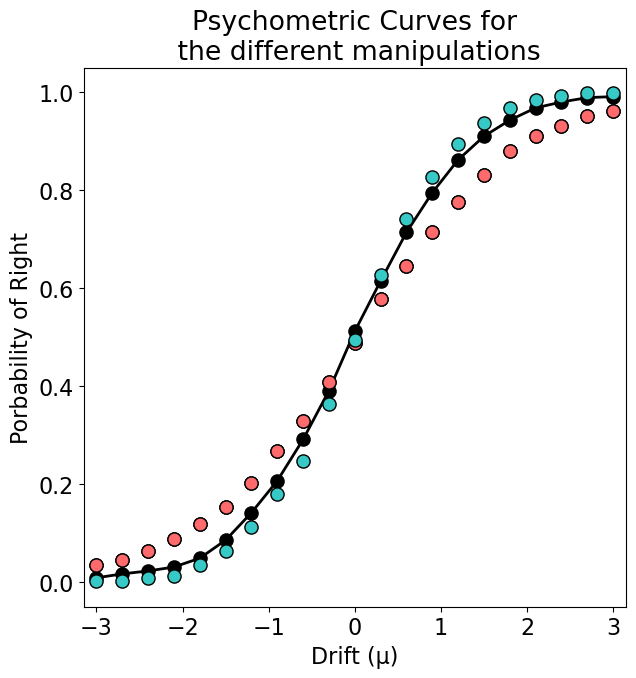

In [17]:
prob_contr = ddm.calc_psychometric(S_list_contr, mu_list)
prob_sens = ddm.calc_psychometric(S_list_sens, mu_list)
prob_evid = ddm.calc_psychometric(S_list_evid, mu_list)
prob_deci = ddm.calc_psychometric(S_list_deci, mu_list)

optocolor_sens = [255/255, 167/255, 55/255]
optocolor_evid = [255/255, 107/255, 108/255]
optocolor_deci = [54/255, 201/255, 198/255]


fig = plt.figure(figsize=(7,7))
plt.plot(mu_list, prob_contr, color='k', linewidth= 2,zorder=1)
pddm.plot_psychometric(prob_contr, mu_list, [0, 0, 0])
pddm.plot_psychometric(prob_sens, mu_list, optocolor_sens)
pddm.plot_psychometric(prob_evid, mu_list, optocolor_evid)
pddm.plot_psychometric(prob_deci, mu_list, optocolor_deci)

plt.title('Psychometric Curves for\n the different manipulations')
plt.show()
fig.savefig('ManipulationPsychometricCurveDiffTemporal_0-1.png', format='png', dpi=900)


0

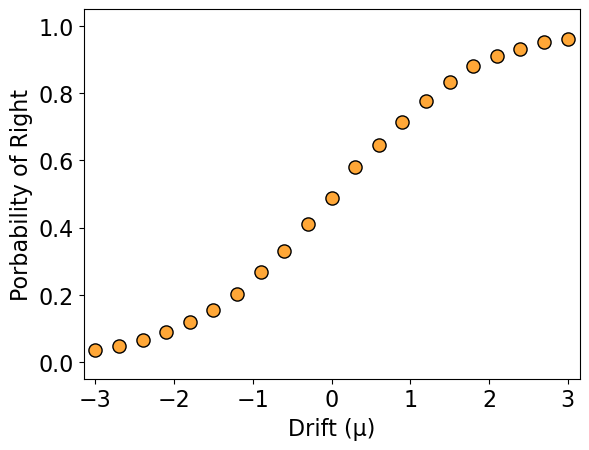

In [16]:
pddm.plot_psychometric(prob_sens, mu_list, optocolor_sens)
